# Assignment #6 [Part 2]
#### In this assignment we are going to train the MNIST dataset and we have to achieve 99.4% validation accuracy using less than 20K parameters under 20 epochs.


### Step 1: Import the required modules

In [1]:
!pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

### Step 2: Defining the model

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, bias=False),      # 28x28x1   -> 28x28x8  -> RF 3
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 8, 3, padding=1, bias=False),      # 28x28x8   -> 28x28x8  -> RF 5
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 8, 3, padding=1, bias=False),      # 28x28x8   -> 28x28x8  -> RF 7
            nn.ReLU(),
            nn.BatchNorm2d(8),

            nn.MaxPool2d(2,2),                              # 28x28x8   -> 14x14x8  -> RF 8
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0, bias=False),     # 14x14x8   -> 12x12x16 -> RF 12
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0, bias=False),    # 12x12x16  -> 10x10x16 -> RF 16
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0, bias=False),    # 10x10x16  -> 8x8x16 -> RF 20
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0, bias=False),    # 8x8x16    -> 6x6x16   -> RF 24
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, 3, padding=0, bias=False),    # 6x6x16    -> 4x4x32   -> RF 28
        )
        self.avgpool = nn.AvgPool2d(4)                      # 4x4x32    -> 1x1x32
        self.fc = nn.Sequential(
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = x.view(-1, 32)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x


### Step 3: View the summary of the model

In [3]:
# Checking if we have CUDA enabled GPU or not
using_cuda = torch.cuda.is_available()
print("Using CUDA!" if using_cuda else "Not using CUDA.")
device = torch.device("cuda" if using_cuda else "cpu")

model = Network().to(device)
summary(model, input_size=(1, 28, 28))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             576
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7            [-1, 8, 28, 28]             576
              ReLU-8            [-1, 8, 28, 28]               0
       BatchNorm2d-9            [-1, 8, 28, 28]              16
        MaxPool2d-10            [-1, 8, 14, 14]               0
          Dropout-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 16, 12, 12]           1,152
             ReLU-13           [-1, 16, 12, 12]               0
      BatchNorm2d-14       

### Step 4 : Preparing the Training and Testing Data

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if using_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



### Step 5 : Defining Training and Testing for the model

In [5]:
from tqdm import tqdm

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def GetCorrectPredCount(pPrediction, pLabels ):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)  # Pass Batch

        # Calculate loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()     # Calculate Gradients
        optimizer.step()    # Update Weights

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Step 6: Train and Test the model

In [6]:
# initialize CNN, cost, and optimizer
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss # with log_softmax() as the last layer, this is equivalent to cross entropy loss
num_epochs = 20

for epoch in range(1, num_epochs):
    print('\n __________ Epoch: {} __________\n'.format(epoch))
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    # scheduler.step()


 __________ Epoch: 1 __________



Train: Loss=0.0847 Batch_id=468 Accuracy=90.84: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]



Test set: Average loss: 0.0478, Accuracy: 9859/10000 (98.59%)


 __________ Epoch: 2 __________



Train: Loss=0.0291 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0338, Accuracy: 9892/10000 (98.92%)


 __________ Epoch: 3 __________



Train: Loss=0.0247 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]



Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)


 __________ Epoch: 4 __________



Train: Loss=0.0188 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)


 __________ Epoch: 5 __________



Train: Loss=0.0560 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)


 __________ Epoch: 6 __________



Train: Loss=0.0963 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)


 __________ Epoch: 7 __________



Train: Loss=0.0081 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)


 __________ Epoch: 8 __________



Train: Loss=0.0063 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)


 __________ Epoch: 9 __________



Train: Loss=0.0237 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.06it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)


 __________ Epoch: 10 __________



Train: Loss=0.0040 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)


 __________ Epoch: 11 __________



Train: Loss=0.0029 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]



Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)


 __________ Epoch: 12 __________



Train: Loss=0.0085 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)


 __________ Epoch: 13 __________



Train: Loss=0.0140 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]



Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)


 __________ Epoch: 14 __________



Train: Loss=0.0308 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)


 __________ Epoch: 15 __________



Train: Loss=0.0136 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:18<00:00, 24.99it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)


 __________ Epoch: 16 __________



Train: Loss=0.0017 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]



Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)


 __________ Epoch: 17 __________



Train: Loss=0.0022 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0169, Accuracy: 9952/10000 (99.52%)


 __________ Epoch: 18 __________



Train: Loss=0.0011 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)


 __________ Epoch: 19 __________



Train: Loss=0.0284 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)



### Step 7 : Analyze Training, Testing Loss and Accuracy

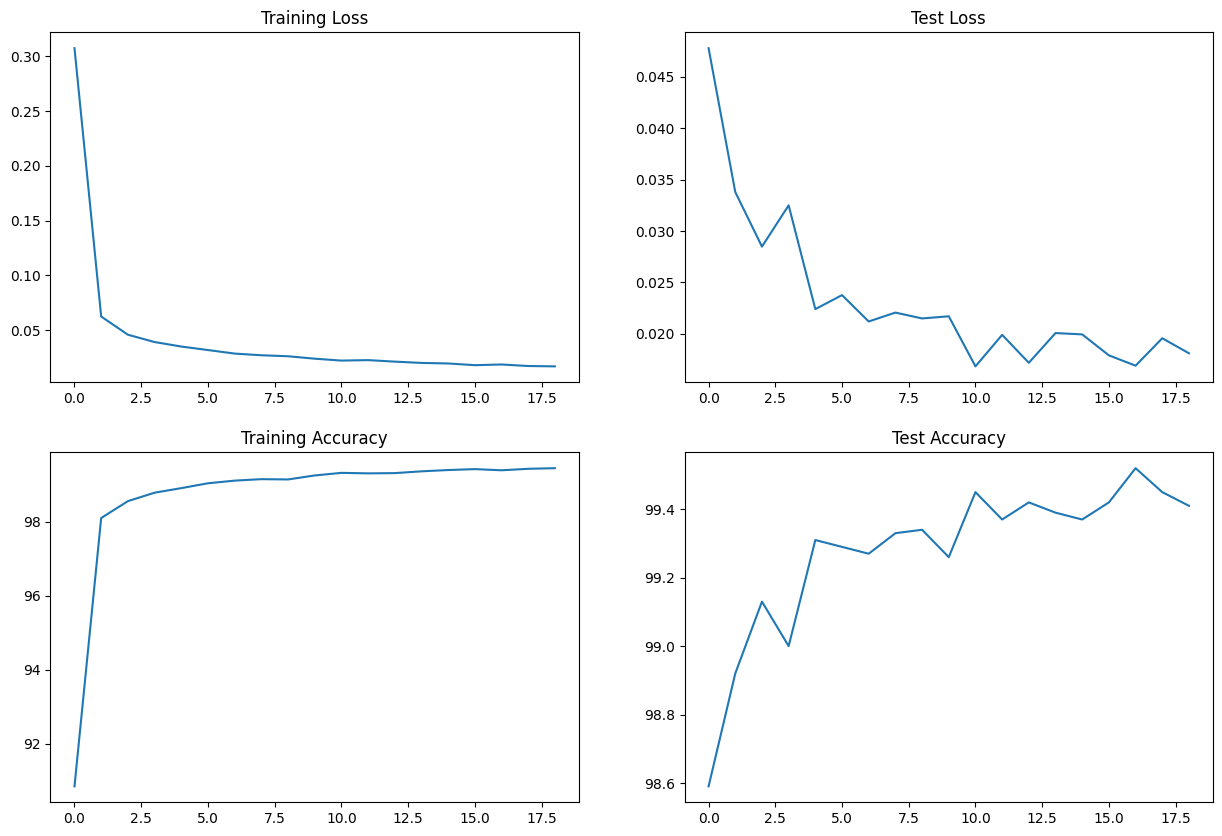

In [7]:
def viewAnalysis(train_losses, train_acc, test_losses, test_acc):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

viewAnalysis(train_losses, train_acc, test_losses, test_acc)
